In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch.nn import Softplus #smooth relu
import torch.nn as nn
import torch.nn.functional as F
from utils import generate_polynomial_data
import numpy as np
import torch
import torch.optim as optim
from torch.nn import MSELoss, BCELoss
from tqdm import tqdm
import pickle
from model import Net, check_loss_landscape

import matplotlib.pyplot as plt

/home/cwang506/.conda/envs/torch-env/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [4]:
torch.manual_seed(0)
suffix = "1"

n = 20
d = 10000
generate_data = False
usepickle = True

coeffs = -1+2*np.random.rand(d, 1)
xvals = -1+2*np.random.rand(n)
fileend = ".pickle" if usepickle else ".npy"

if generate_data:
    print("Generating Data...")
    X, Y = generate_polynomial_data(coeffs, xvals)
    #make categorical
    inds_pos = np.where(Y>0)
    inds_neg = np.where(Y<=0)
#     print(Y)
    Y[inds_pos] = 1
    Y[inds_neg] = 0
    with open("./datasets/X_categorical_%s%s" %(("pickle_" if usepickle else ""), sufix)+fileend, "wb") as f:
        if usepickle:
            pickle.dump(X, f)
        else:
            np.save(f, X)
    with open("./datasets/Y_categorical_%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "wb") as f:
        if usepickle:
            pickle.dump(Y, f)
        else:
            np.save(f, Y)
    with open("./datasets/coeffs_categorical_%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "wb") as f:
        if usepickle:
            pickle.dump(coeffs, f)
        else:
            np.save(f, coeffs)
    
else:
    with open("./datasets/X_categorical_%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            X = pickle.load(f)
        else:
            X = np.load(f)
    with open("./datasets/Y_categorical_%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            Y = pickle.load(f)
        else:
            Y = np.load(f)
    with open("./datasets/coeffs_categorical_%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            coeffs = pickle.load(f)
        else:
            coeffs = np.load(f)

In [5]:
#subsample to get 50/50 split
inds_pos = np.where(Y==1)[0]
inds_neg = np.where(Y==0)[0]
pos = np.random.choice(inds_pos, size=int(20/2))
neg = np.random.choice(inds_neg, size=int(20/2))
data_inds = np.concatenate([pos, neg])
data_inds.sort()
X, Y = X[data_inds], Y[data_inds]

Running on GPU


  0%|          | 0/10 [00:00<?, ?it/s]

Running on GPU
0.01


/home/cwang506/.conda/envs/torch-env/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0\epochLoss =  0.6936

 10%|█         | 1/10 [17:11<2:34:42, 1031.41s/it]

epoch: 0\epochLoss =  0.6950.008
epoch: 1\epochLoss =  0.000

 20%|██        | 2/10 [34:21<2:17:27, 1030.95s/it]

epoch: 1\epochLoss =  0.0020.0064
epoch: 2\epochLoss =  0.000

 30%|███       | 3/10 [51:29<2:00:10, 1030.04s/it]

epoch: 2\epochLoss =  0.0000.00512
epoch: 3\epochLoss =  0.001

 40%|████      | 4/10 [1:08:37<1:42:57, 1029.65s/it]

epoch: 3\epochLoss =  0.0000.004096000000000001
epoch: 4\epochLoss =  0.001

 50%|█████     | 5/10 [1:25:44<1:25:43, 1028.80s/it]

epoch: 4\epochLoss =  0.0000.0032768000000000007
epoch: 5\epochLoss =  0.000

 60%|██████    | 6/10 [1:42:47<1:08:28, 1027.04s/it]

epoch: 5\epochLoss =  0.0000.002621440000000001
epoch: 6\epochLoss =  0.000

 70%|███████   | 7/10 [1:59:49<51:16, 1025.55s/it]  

epoch: 6\epochLoss =  0.0010.002097152000000001
epoch: 7\epochLoss =  0.000

 80%|████████  | 8/10 [2:16:53<34:09, 1024.88s/it]

epoch: 7\epochLoss =  0.0010.001677721600000001
epoch: 8\epochLoss =  0.000

 90%|█████████ | 9/10 [2:34:00<17:05, 1025.57s/it]

epoch: 8\epochLoss =  0.0000.0013421772800000008
epoch: 9\epochLoss =  0.000

100%|██████████| 10/10 [2:51:09<00:00, 1026.92s/it]

epoch: 9\epochLoss =  0.001

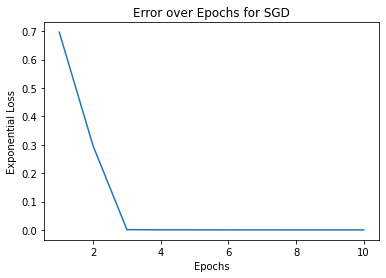

In [ ]:
torch.manual_seed(0)

sgd = True
train = True

if sgd:
    model_path = "./models/model_sgd_categorical_%s.pt"%suffix
    net = Net(d, epochs = 10, loss = BCELoss(reduction="sum"), categorical = True)
else:
    model_path = "./models/model_categorical_%s.pt"%suffix
    net = Net(d, epochs = 20, loss = BCELoss(reduction="sum"), categorical = True)
    
if train:
    usegpu=True
    if torch.cuda.is_available() and usegpu:
        device = torch.device("cuda:0")
        print("Running on GPU")
    else:
        device = torch.device("cpu")
    net.to(device)
    if sgd:
        net.train_sgd(X, Y, 100000, lr = 1e-2, usegpu = usegpu)
    else:
        net.train_gd(X, Y, 2000, lr = 1e-3, usegpu = usegpu)
    torch.save(net.state_dict(), model_path)

True


/home/cwang506/.conda/envs/torch-env/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Overall loss: tensor(0.0222, grad_fn=<BinaryCrossEntropyBackward>)
1.617239831830375e-05 0.0
1.23447629896134e-09 0.0
1.168254780161336e-28 0.0
0.9980729818344116 1.0
0.9981424808502197 1.0
1.4208529819370597e-07 0.0
0.9981422424316406 1.0
4.2774377106979955e-06 0.0
0.9975117444992065 1.0
6.060698069632053e-06 0.0
0.00044137093937024474 0.0
0.0 0.0
4.1088375354078186e-21 0.0
0.9981422424316406 1.0
0.9981181621551514 1.0
1.2642435539504832e-23 0.0
0.995978593826294 1.0
0.9981359243392944 1.0
0.9978716373443604 1.0
0.9981366395950317 1.0
[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]


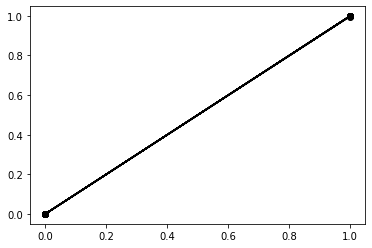

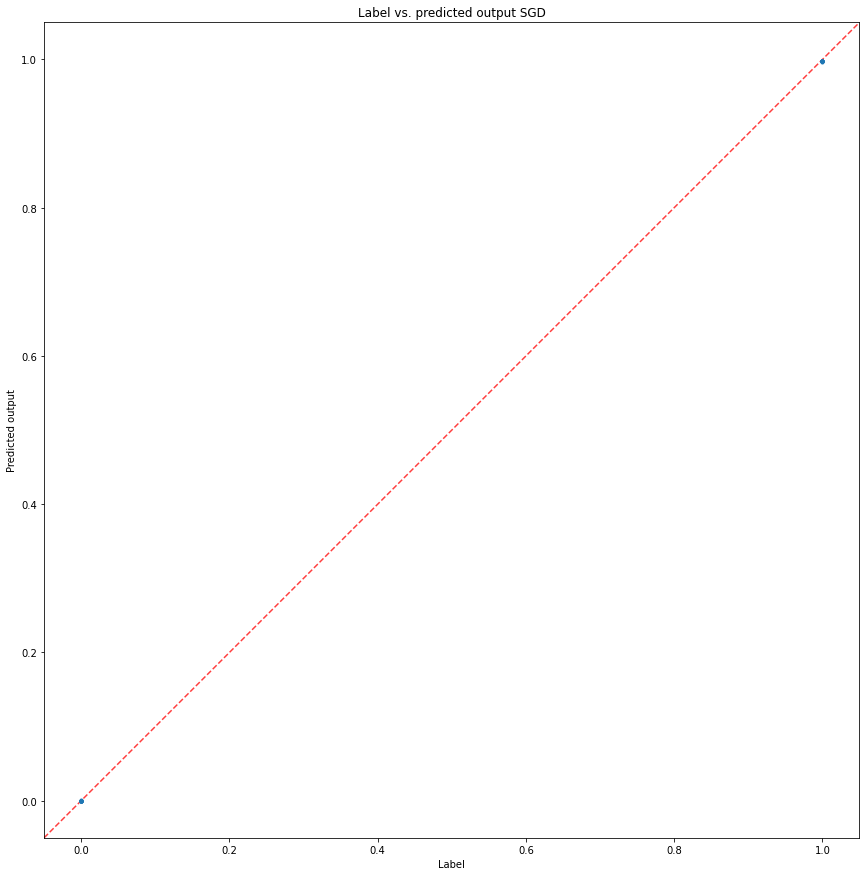

In [14]:
check_loss_landscape(model_path, X, Y, sgd = True,loss_function = BCELoss(reduction="sum"), categorical=True )